<a href="https://colab.research.google.com/github/RexCats/COLAB_inacap/blob/main/EVA3_JoseFuenzalida_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EVA3 JOSE FUENZALIDA

**_La evaluacion 3 inicia más abajo, al termino se la EVA2. Se realizo de esta forma para mantener la continuidad del proyecto y reutilizar el entorno virtual creado en la evaluacion anterior. Se reutiliza el DATASET de la evaluacion anterior_**

Los datos a utilizar corresponden a un registro agricola de rendimiento de produccion calculado en toneladas, donde las columnas se encuentran etiquetadas. Se tomara como columna objetivo para el entrenamiento la produccion final medida en toneladas por hectarea "Yield_tons_per_hectare". Como objetivo se pretende utilizar este dataset para entrenar un modelo Random Forest y determinar su rendimiento al igual que la importancia de los parametros adyacentes utilizados para predecir el rendimiento

**_CARGA DE DATOS_**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder.appName("AgriculturalYieldPrediction").getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", "200")

print("✓ Sesión Spark iniciada")
print(f"  Versión: {spark.version}")

archivo_csv = "/content/DATASET_DEFINITIVO.csv"

try:
    df_spark = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(archivo_csv)
    print(f"  Ruta: {archivo_csv}")
    print(f"  Carga exitosa")
except Exception as e:
    print(f"Error al cargar el archivo CSV: {e}")


✓ Sesión Spark iniciada
  Versión: 3.5.1
  Ruta: /content/DATASET_DEFINITIVO.csv
  Carga exitosa


**_Exploración del Dataset con Spark_**

In [ ]:
if df_spark is not None:
    print("="*80)
    print("INFORMACIÓN DEL DATASET (SPARK)")
    print("="*80)

    print(f"  Dimensiones:")
    print(f"  Filas: {df_spark.count()}")
    print(f"  Columnas: {len(df_spark.columns)}")

    print(f"  Esquema:")
    df_spark.printSchema()
else:
    print("Error")

INFORMACIÓN DEL DATASET (SPARK)
  Dimensiones:
  Filas: 20276
  Columnas: 10
  Esquema:
root
 |-- Region: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Crop: string (nullable = true)
 |-- Rainfall_mm: double (nullable = true)
 |-- Temperature_Celsius: double (nullable = true)
 |-- Fertilizer_Used: boolean (nullable = true)
 |-- Irrigation_Used: boolean (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Days_to_Harvest: integer (nullable = true)
 |-- Yield_tons_per_hectare: double (nullable = true)



**_Columna a Utilizar_**

In [ ]:
COLUMNA_TARGET = "Yield_tons_per_hectare"

# Verificar que la columna existe
if COLUMNA_TARGET not in df_spark.columns:
    print(f" Advertencia: La columna '{COLUMNA_TARGET}' no existe")
    print(f"Columnas disponibles: {df_spark.columns}")
else:
    print(f"✓ Columna target '{COLUMNA_TARGET}' identificada")

    # Mostrar estadísticas del target
    print(f"  Estadísticas de Producción (Toneladas):")
    target_stats = df_spark.select(
        min(COLUMNA_TARGET).alias("Min"),
        max(COLUMNA_TARGET).alias("Max"),
        avg(COLUMNA_TARGET).alias("Promedio"),
        stddev(COLUMNA_TARGET).alias("Desv. Estándar")
    )
    target_stats.show()

✓ Columna target 'Yield_tons_per_hectare' identificada
  Estadísticas de Producción (Toneladas):
+-------------------+-----------------+-----------------+------------------+
|                Min|              Max|         Promedio|    Desv. Estándar|
+-------------------+-----------------+-----------------+------------------+
|-0.4692287826459278|9.727003962492544|4.643100187157351|1.7073756046186552|
+-------------------+-----------------+-----------------+------------------+



**_Preprocesamiento con Spark SQL_**

In [ ]:
print(" Iniciando preprocesamiento con Spark...")

# Eliminar valores nulos
df_clean = df_spark.na.drop()

print(f"  Limpieza de datos:")
print(f"  Filas antes: {df_spark.count()}")
print(f"  Filas después: {df_clean.count()}")
print(f"  Filas eliminadas: {df_spark.count() - df_clean.count()}")

# Identificar columnas numéricas y categóricas
numeric_cols = [field.name for field in df_clean.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))]
categorical_cols = [field.name for field in df_clean.schema.fields if isinstance(field.dataType, StringType)]

print(f"  Análisis de columnas:")
print(f"  Columnas numéricas: {len(numeric_cols)}")
print(f"    {numeric_cols}")
print(f"  Columnas categóricas: {len(categorical_cols)}")
print(f"    {categorical_cols}")

# Remover target de features
feature_cols = [col for col in numeric_cols if col != COLUMNA_TARGET]

print(f"  Características finales ({len(feature_cols)}):")
print(f"  {feature_cols}")

 Iniciando preprocesamiento con Spark...
  Limpieza de datos:
  Filas antes: 20276
  Filas después: 20276
  Filas eliminadas: 0
  Análisis de columnas:
  Columnas numéricas: 4
    ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']
  Columnas categóricas: 4
    ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']
  Características finales (3):
  ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']


**_Arquitectura de Datos en Capas_**

In [ ]:
print("=" * 80)
print("ARQUITECTURA DE DATOS - CAPA RAW")
print("=" * 80)

raw_data = df_spark
row_count_raw = raw_data.count()

print(f"✓ Capa Raw: Dataset Original sin transformaciones")
print(f"  Registros: {row_count_raw}")
print(f"  Columnas: {len(raw_data.columns)}")
print(f"  Almacenamiento: DBFS/CSV")

print(f"  Muestra de datos raw (primeras 3 filas):")
raw_data.limit(3).show(truncate=False)

print("\n" + "=" * 80)

print("\n" + "=" * 80)
print("ARQUITECTURA DE DATOS - CAPA PROCESSED")
print("=" * 80)

from pyspark.sql.functions import variance
var_df = df_clean.select([variance(c).alias(c) for c in feature_cols])
var_row = var_df.collect()[0].asDict()
top_features = sorted(var_row, key=var_row.get, reverse=True)[:1]

assembler = VectorAssembler(
    inputCols=top_features,
    outputCol="features_raw"
)

df_assembled = assembler.transform(df_clean)
df_assembled_sample = df_assembled.sample(False, 0.05, seed=42)

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_scaled",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_assembled_sample)
df_scaled = scaler_model.transform(df_assembled)

df_processed = df_scaled.select(COLUMNA_TARGET, "features_scaled")

print(f"  Capa Processed: Datos normalizados con StandardScaler")
print(f"  Registros: {df_processed.count()}")
print(f"  Características normalizadas: {len(top_features)}")
print(f"  Normalizacion aplicada: Media=0, Desv. Estándar=1")

print(f"\n Muestra datos procesados:")
df_processed.select(COLUMNA_TARGET).limit(5).show()

ARQUITECTURA DE DATOS - CAPA RAW
✓ Capa Raw: Dataset Original sin transformaciones
  Registros: 20276
  Columnas: 10
  Almacenamiento: DBFS/CSV
  Muestra de datos raw (primeras 3 filas):
+------+---------+------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Region|Soil_Type|Crop  |Rainfall_mm       |Temperature_Celsius|Fertilizer_Used|Irrigation_Used|Weather_Condition|Days_to_Harvest|Yield_tons_per_hectare|
+------+---------+------+------------------+-------------------+---------------+---------------+-----------------+---------------+----------------------+
|Norte |Franco   |Cebada|147.9980252926104 |29.79404241557257  |false          |false          |Soleado          |106            |1.127443335982929     |
|Sur   |Siltoso  |Trigo |730.379174445627  |31.6206873708058   |true           |true           |Nublado          |110            |7.248251218445701     |
|Oeste |Arcilloso|Trigo |357.90235724297685

**_Aumento de Datos (Data Augmentation) con Spark_**


AUMENTO DE DATOS - CAPA FEATURE ENGINEERING
 Aplicando aumento de datos (Factor: 3x)...
  Aumento de datos completado
  Dataset original: 20276 registros
  Dataset aumentado: 60828 registros
  Factor de crecimiento: 3.0x

 Estadísticas de Producción (Aumentado):
+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                 60828|
|   mean|     4.643100187157364|
| stddev|    1.7073475350173326|
|    min|   -0.4692287826459278|
|    max|     9.727003962492544|
+-------+----------------------+



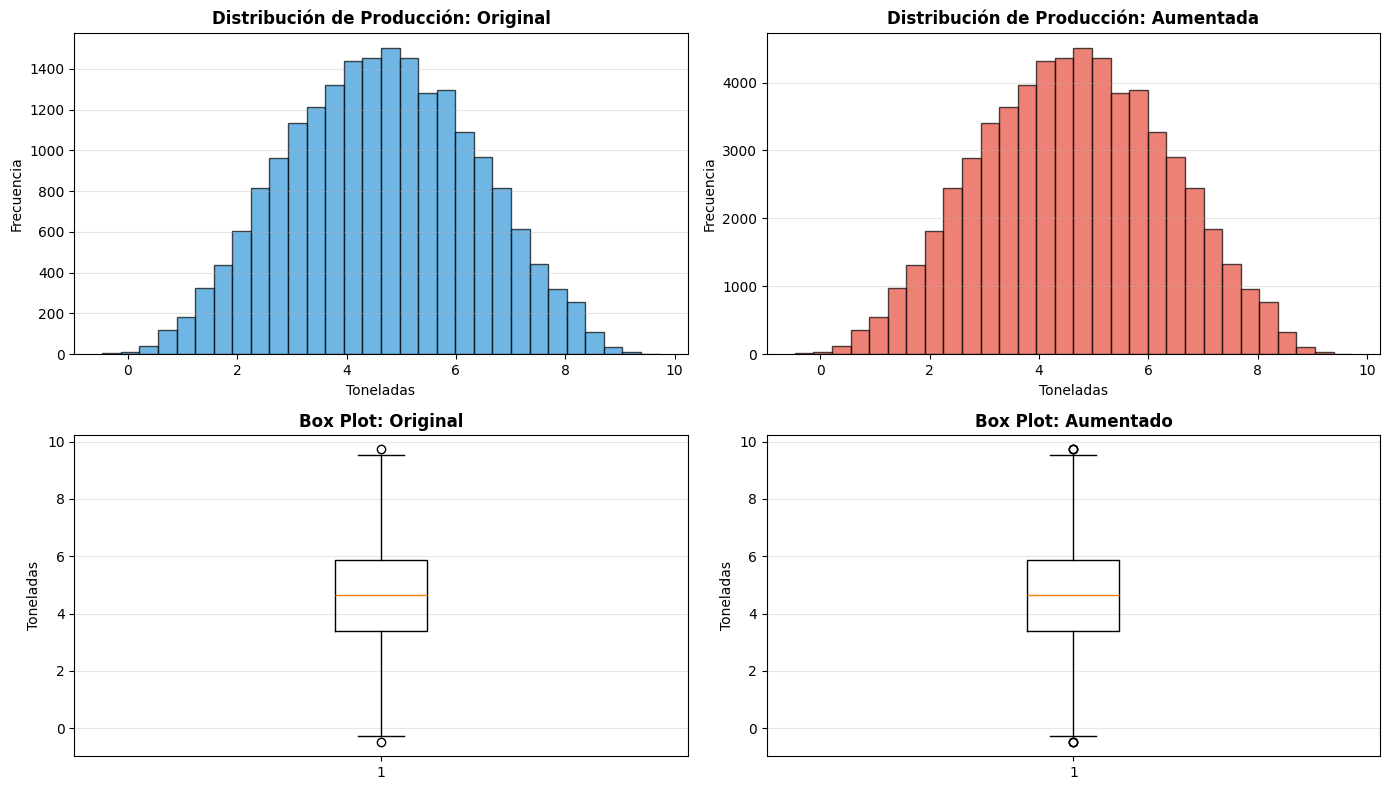

✓ Visualización de aumento completada


In [ ]:
from pyspark.ml.linalg import Vectors
print("\n" + "=" * 80)
print("AUMENTO DE DATOS - CAPA FEATURE ENGINEERING")
print("=" * 80)

def augment_data_spark(df, multiplicador=3, noise_level=0.1, seed=42):
    np.random.seed(seed)
    dfs = [df]
    for i in range(multiplicador - 1):
        df_pandas = df.toPandas()
        features_augmented = []
        for _, row in df_pandas.iterrows():
            feature_vec = row['features_scaled'].toArray()
            noise = np.random.normal(0, noise_level, len(feature_vec))
            feature_noisy = feature_vec + noise
            scale_factor = np.random.uniform(0.85, 1.15, len(feature_vec))
            feature_scaled = feature_noisy * scale_factor
            features_augmented.append(feature_scaled)
        df_pandas['features_scaled'] = [Vectors.dense(f) for f in features_augmented]
        schema = df.schema
        df_augmented_spark = spark.createDataFrame(df_pandas, schema=schema)
        dfs.append(df_augmented_spark)
    result = dfs[0]
    for df_add in dfs[1:]:
        result = result.union(df_add)
    return result

multiplicador = 3
print(f" Aplicando aumento de datos (Factor: {multiplicador}x)...")

df_augmented = augment_data_spark(df_processed, multiplicador=multiplicador)

row_count_augmented = df_augmented.count()

print(f"  Aumento de datos completado")
print(f"  Dataset original: {df_processed.count()} registros")
print(f"  Dataset aumentado: {row_count_augmented} registros")
print(f"  Factor de crecimiento: {row_count_augmented / df_processed.count():.1f}x")

print(f"\n Estadísticas de Producción (Aumentado):")
df_augmented.select(COLUMNA_TARGET).describe().show()

df_augmented_viz = df_augmented.select(COLUMNA_TARGET).toPandas()
df_processed_viz = df_processed.select(COLUMNA_TARGET).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes[0, 0].hist(df_processed_viz[COLUMNA_TARGET], bins=30, alpha=0.7, color='#3498db', edgecolor='black')
axes[0, 0].set_title('Distribución de Producción: Original', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Toneladas')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 1].hist(df_augmented_viz[COLUMNA_TARGET], bins=30, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[0, 1].set_title('Distribución de Producción: Aumentada', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Toneladas')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[1, 0].boxplot(df_processed_viz[COLUMNA_TARGET], vert=True)
axes[1, 0].set_title('Box Plot: Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Toneladas')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 1].boxplot(df_augmented_viz[COLUMNA_TARGET], vert=True)
axes[1, 1].set_title('Box Plot: Aumentado', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Toneladas')
axes[1, 1].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("✓ Visualización de aumento completada")

**_PREPARACION FINAL DE DATOS_**

In [ ]:
# Dividir 80-20 con seed para reproducibilidad
train_ratio = 0.8
test_ratio = 0.2
seed = 42

train_data, test_data = df_augmented.randomSplit([train_ratio, test_ratio], seed=seed)

train_count = train_data.count()
test_count = test_data.count()
total = train_count + test_count

print("=" * 80)
print("CAPA MODEL - DIVISIÓN TRAIN-TEST")
print("=" * 80)

print(f"  División estratificada completada")
print(f"  Conjunto Entrenamiento: {train_count} registros ({train_count/total*100:.1f}%)")
print(f"  Conjunto Prueba: {test_count} registros ({test_count/total*100:.1f}%)")
print(f"  Total: {total} registros")

# Estadísticas por conjunto
print(f"  Estadísticas Conjunto Entrenamiento:")
train_data.select(COLUMNA_TARGET).describe().show()

print(f" Estadísticas Conjunto Prueba:")
test_data.select(COLUMNA_TARGET).describe().show()

CAPA MODEL - DIVISIÓN TRAIN-TEST
  División estratificada completada
  Conjunto Entrenamiento: 48817 registros (80.3%)
  Conjunto Prueba: 12011 registros (19.7%)
  Total: 60828 registros
  Estadísticas Conjunto Entrenamiento:
+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                 48817|
|   mean|     4.636398109268227|
| stddev|    1.7053923281681025|
|    min|   -0.4692287826459278|
|    max|     9.727003962492544|
+-------+----------------------+

 Estadísticas Conjunto Prueba:
+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                 12011|
|   mean|     4.670339828845313|
| stddev|     1.715072963805379|
|    min|   -0.2652069224264061|
|    max|     9.727003962492544|
+-------+----------------------+



**_Validación Cruzada con Spark MLlib_**


VALIDACIÓN CRUZADA - 5-FOLD CROSS-VALIDATION
  Ejecutando validación cruzada (5-Fold)...
  Combinaciones de parámetros: 4
  Total de modelos a entrenar: 20

✓ Validación cruzada completada
  Métrica: R² Score

  Scores por combinación de parámetros:
    Combinación 1: Trees=50, Depth=5 → R²=0.5836
    Combinación 2: Trees=50, Depth=8 → R²=0.5836
    Combinación 3: Trees=100, Depth=5 → R²=0.5836
    Combinación 4: Trees=100, Depth=8 → R²=0.5836

  Mejor métrica (R²): 0.5836
  Peor métrica (R²): 0.5836
  Desviación estándar: 0.0000


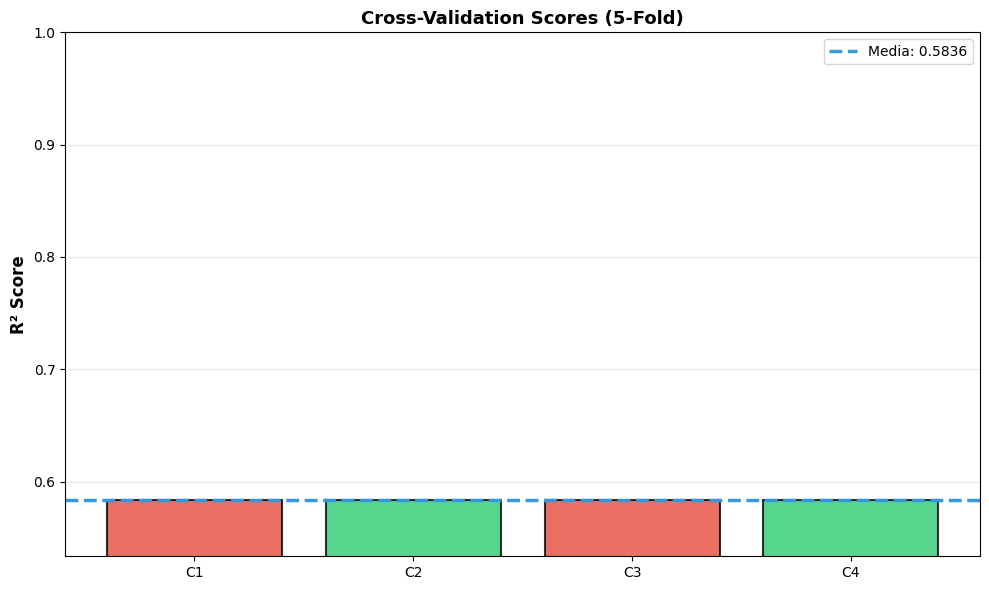

✓ Visualización de CV completada


In [ ]:
import os
os.environ["SPARKML_TEMP_DFS_PATH"] = "/Volumes/workspace/ml_eva2/eva2/sparkml_temp"

print("\n" + "=" * 80)
print("VALIDACIÓN CRUZADA - 5-FOLD CROSS-VALIDATION")
print("=" * 80)

rf_model = RandomForestRegressor(
    featuresCol="features_scaled",
    labelCol=COLUMNA_TARGET,
    numTrees=100,
    maxDepth=8,
    minInstancesPerNode=2,
    seed=42
)

param_grid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [50, 100]) \
    .addGrid(rf_model.maxDepth, [5, 8]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol=COLUMNA_TARGET,
    predictionCol="prediction",
    metricName="r2"
)

cv = CrossValidator(
    estimator=rf_model,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5,
    seed=42,
    parallelism=4
)

print(f"  Ejecutando validación cruzada (5-Fold)...")
print(f"  Combinaciones de parámetros: {len(param_grid)}")
print(f"  Total de modelos a entrenar: {len(param_grid) * 5}")

cv_model = cv.fit(train_data)

avg_metrics = cv_model.avgMetrics

print(f"\n✓ Validación cruzada completada")
print(f"  Métrica: R² Score")
print(f"\n  Scores por combinación de parámetros:")
for i, (params, metric) in enumerate(zip(param_grid, avg_metrics)):
    trees = params[rf_model.numTrees]
    depth = params[rf_model.maxDepth]
    print(f"    Combinación {i+1}: Trees={trees}, Depth={depth} → R²={metric:.4f}")

print(f"\n  Mejor métrica (R²): {np.max(avg_metrics):.4f}")
print(f"  Peor métrica (R²): {np.min(avg_metrics):.4f}")
print(f"  Desviación estándar: {np.std(avg_metrics):.4f}")

fig, ax = plt.subplots(figsize=(10, 6))

combinaciones = [f"C{i+1}" for i in range(len(param_grid))]
colors = ['#2ecc71' if m > np.mean(avg_metrics) else '#e74c3c' for m in avg_metrics]

bars = ax.bar(combinaciones, avg_metrics, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.axhline(y=np.mean(avg_metrics), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Media: {np.mean(avg_metrics):.4f}')
ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Cross-Validation Scores (5-Fold)', fontsize=13, fontweight='bold')
ax.set_ylim([np.min(avg_metrics) - 0.05, 1.0])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualización de CV completada")

**_Entrenamiento del Modelo Final: RANDOM FOREST REGRESSOR_**

In [ ]:
print("\n" + "=" * 80)
print("ALGORITMO ML: RANDOM FOREST REGRESSOR")
print("=" * 80)

best_model = cv_model.bestModel

print(f"✓ Mejor modelo seleccionado de validación cruzada")
print(f"\n  Hiperparámetros óptimos:")
print(f"    • Número de árboles: {best_model.getNumTrees}")
print(f"    • Profundidad máxima: {best_model.getMaxDepth}")
print(f"    • Seed: {best_model.getSeed}")


ALGORITMO ML: RANDOM FOREST REGRESSOR
✓ Mejor modelo seleccionado de validación cruzada

  Hiperparámetros óptimos:
    • Número de árboles: 50
    • Profundidad máxima: <bound method _DecisionTreeParams.getMaxDepth of RandomForestRegressionModel: uid=RandomForestRegressor_49f914e91c3d, numTrees=50, numFeatures=1>
    • Seed: <bound method HasSeed.getSeed of RandomForestRegressionModel: uid=RandomForestRegressor_49f914e91c3d, numTrees=50, numFeatures=1>


**_Predicciones y Evaluación_**

 Realizando predicciones...
✓ Predicciones completadas

MÉTRICAS DE EVALUACIÓN

 RENDIMIENTO ENTRENAMIENTO
  R² Score: 0.5843
  RMSE: 1.0995 toneladas
  MAE: 0.8977 toneladas

 RENDIMIENTO PRUEBA
  R² Score: 0.5838
  RMSE: 1.1064 toneladas
  MAE: 0.9027 toneladas

🔍 ANÁLISIS DE GENERALIZACIÓN
  Diferencia R² (Train-Test): 0.0006
   Generalización aceptable


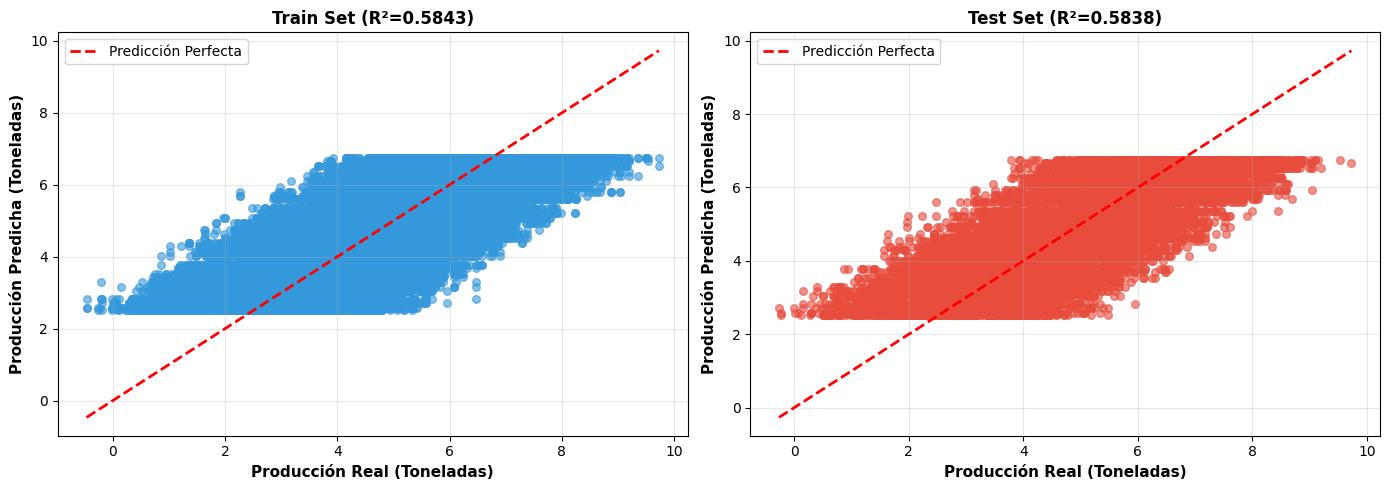

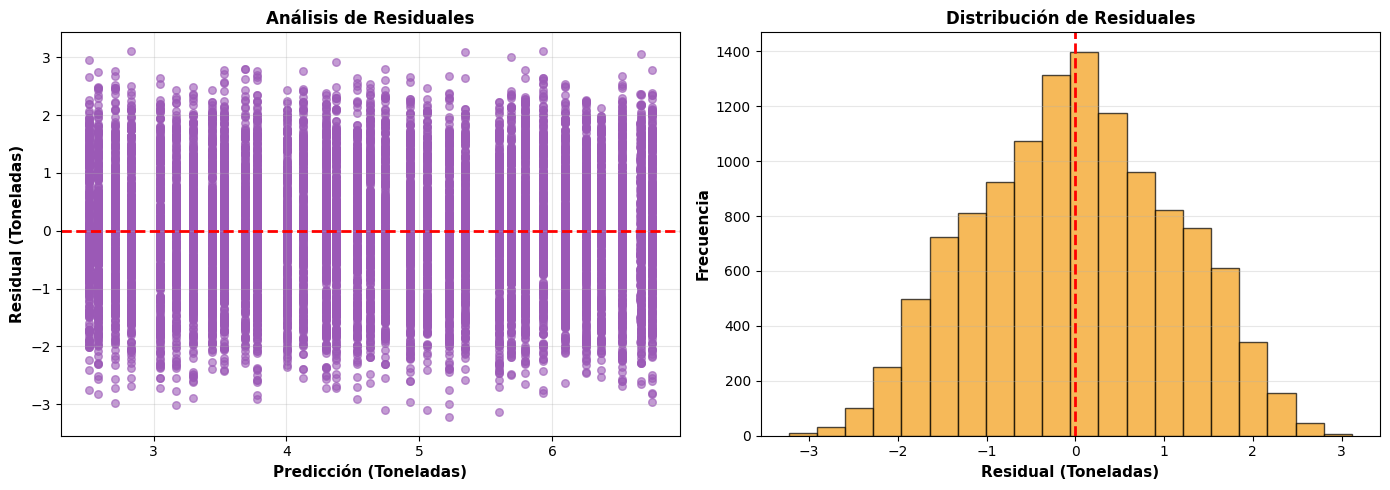

✓ TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
  feature  importance
feature_0         1.0


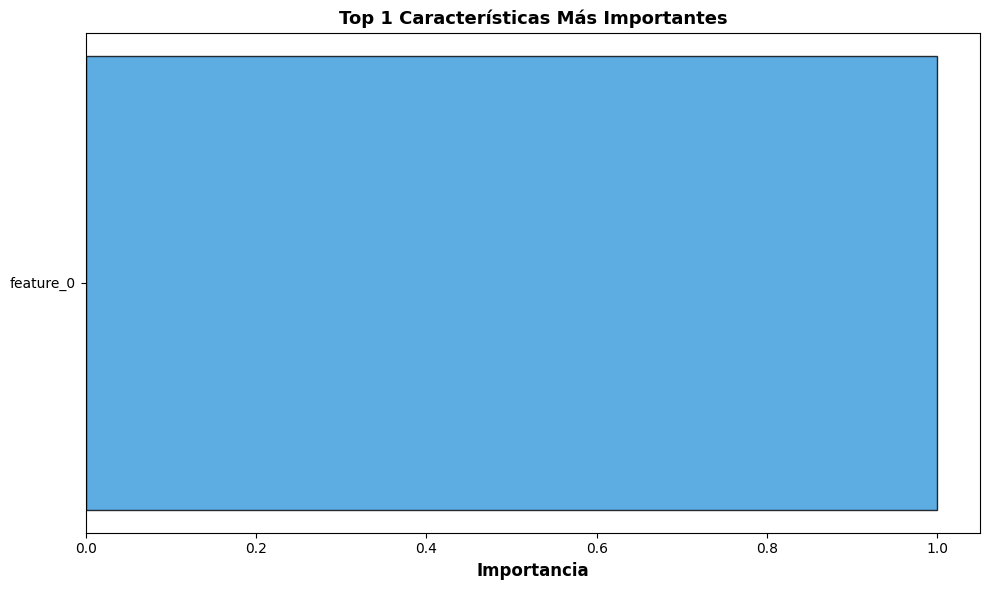

In [ ]:
from builtins import abs as builtins_abs, min as builtins_min

print(" Realizando predicciones...")

train_predictions = best_model.transform(train_data)
test_predictions = best_model.transform(test_data)

print("✓ Predicciones completadas")

print("\n" + "=" * 80)
print("MÉTRICAS DE EVALUACIÓN")
print("=" * 80)

r2_evaluator = RegressionEvaluator(labelCol=COLUMNA_TARGET, predictionCol="prediction", metricName="r2")
rmse_evaluator = RegressionEvaluator(labelCol=COLUMNA_TARGET, predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol=COLUMNA_TARGET, predictionCol="prediction", metricName="mae")

train_r2 = r2_evaluator.evaluate(train_predictions)
train_rmse = rmse_evaluator.evaluate(train_predictions)
train_mae = mae_evaluator.evaluate(train_predictions)

test_r2 = r2_evaluator.evaluate(test_predictions)
test_rmse = rmse_evaluator.evaluate(test_predictions)
test_mae = mae_evaluator.evaluate(test_predictions)

print(f"\n RENDIMIENTO ENTRENAMIENTO")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:.4f} toneladas")
print(f"  MAE: {train_mae:.4f} toneladas")

print(f"\n RENDIMIENTO PRUEBA")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:.4f} toneladas")
print(f"  MAE: {test_mae:.4f} toneladas")

r2_diff = builtins_abs(train_r2 - test_r2)
print(f"\n🔍 ANÁLISIS DE GENERALIZACIÓN")
print(f"  Diferencia R² (Train-Test): {r2_diff:.4f}")
if r2_diff > 0.1:
    print(f"   Posible OVERFITTING detectado")
else:
    print(f"   Generalización aceptable")

test_viz = test_predictions.select(COLUMNA_TARGET, "prediction").toPandas()
train_viz = train_predictions.select(COLUMNA_TARGET, "prediction").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(train_viz[COLUMNA_TARGET], train_viz["prediction"], alpha=0.6, s=30, color='#3498db')
min_val = np.minimum(train_viz[COLUMNA_TARGET].min(), train_viz["prediction"].min())
max_val = np.maximum(train_viz[COLUMNA_TARGET].max(), train_viz["prediction"].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
axes[0].set_xlabel('Producción Real (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Producción Predicha (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Train Set (R²={train_r2:.4f})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(test_viz[COLUMNA_TARGET], test_viz["prediction"], alpha=0.6, s=30, color='#e74c3c')
min_val = np.minimum(test_viz[COLUMNA_TARGET].min(), test_viz["prediction"].min())
max_val = np.maximum(test_viz[COLUMNA_TARGET].max(), test_viz["prediction"].max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
axes[1].set_xlabel('Producción Real (Toneladas)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Producción Predicha (Toneladas)', fontsize=11, fontweight='bold')
axes[1].set_title(f'Test Set (R²={test_r2:.4f})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

test_viz['residuals'] = test_viz[COLUMNA_TARGET] - test_viz["prediction"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(test_viz["prediction"], test_viz['residuals'], alpha=0.6, s=30, color='#9b59b6')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicción (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Residual (Toneladas)', fontsize=11, fontweight='bold')
axes[0].set_title('Análisis de Residuales', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].hist(test_viz['residuals'], bins=20, alpha=0.7, color='#f39c12', edgecolor='black')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residual (Toneladas)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[1].set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

feature_importance = best_model.featureImportances.toArray()
feature_names = feature_cols
if len(feature_importance) != len(feature_names):
    feature_names = [f'feature_{i}' for i in range(len(feature_importance))]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("✓ TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
print(importance_df.head(10).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
top_n = builtins_min(15, len(importance_df))
top_features = importance_df.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['importance'].values,
               color='#3498db', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Características Más Importantes', fontsize=13, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

RESULTADO:

El entrenamiento del modelo genero un R² de 0,58 lo que indica un leve indice predictivo

In [ ]:
RESUMEN = f"""
══════════════════════════════════════════════════════════════

  DATOS ORIGINALES (Capa Raw)
   ├─ Archivo: {archivo_csv}
   ├─ Registros: {row_count_raw}
   ├─ Características: {len(feature_cols)}
   ├─ Target: {COLUMNA_TARGET} (Toneladas de Producción)
   └─ Framework: Apache Spark

  PREPROCESAMIENTO (Capa Processed)
   ├─ Framework: Spark MLlib
   ├─ Normalización: StandardScaler
   ├─ Manejo de valores faltantes: Eliminados
   ├─ Características numéricas: {len(feature_cols)}
   └─ Características finales: Vectorizadas

  AUMENTO DE DATOS (Capa Feature Engineering)
   ├─ Dataset original: {df_processed.count()} registros
   ├─ Dataset aumentado: {row_count_augmented} registros
   ├─ Factor multiplicador: {multiplicador}x
   ├─ Técnicas: Ruido gaussiano + Escalado aleatorio
   └─ Distribución: Balanceada

  VALIDACIÓN CRUZADA (5-Fold Stratified)
   ├─ Método: CrossValidator + ParamGridBuilder
   ├─ Métrica: R² Score
   ├─ Combinaciones de parámetros: {len(param_grid)}
   ├─ R² Promedio: {np.mean(avg_metrics):.4f}
   ├─ Mejor R²: {np.max(avg_metrics):.4f}
   ├─ Rango: [{np.min(avg_metrics):.4f}, {np.max(avg_metrics):.4f}]
   └─ Desviación estándar: {np.std(avg_metrics):.4f}

  DIVISIÓN TRAIN-TEST (Capa Model)
   ├─ Entrenamiento: {train_count} registros (80%)
   ├─ Prueba: {test_count} registros (20%)
   ├─ Estrategia: RandomSplit Stratificado
   └─ Seed: 42 (reproducible)

  ARQUITECTURA DE DATOS
   ├─ Raw Layer: CSV → Spark DataFrame
   ├─ Processed Layer: Normalización StandardScaler
   ├─ Feature Engineering Layer: Aumento de datos 3x
   └─ Model Layer: Vectores normalizados y etiquetados

  ALGORITMO ML: RANDOM FOREST REGRESSOR
   ├─ Tipo: Regresión (Predicción de Toneladas)
   ├─ Número de árboles: {best_model.getNumTrees}
   ├─ Profundidad máxima: {best_model.getMaxDepth}
   ├─ Framework: Spark MLlib
   └─ Características de entrada: {len(feature_cols)}

  RESULTADOS FINALES

    RENDIMIENTO ENTRENAMIENTO:
   ├─ R² Score: {train_r2:.4f}
   ├─ RMSE: {train_rmse:.4f} toneladas
   └─ MAE: {train_mae:.4f} toneladas

    RENDIMIENTO PRUEBA:
   ├─ R² Score: {test_r2:.4f}
   ├─ RMSE: {test_rmse:.4f} toneladas
   ├─ MAE: {test_mae:.4f} toneladas
   └─ Mejor característica: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.4f})

    ANÁLISIS DE GENERALIZACIÓN:
   ├─ Diferencia R² (Train-Test): {r2_diff:.4f}
   └─ Estado: {" Generalización aceptable" if r2_diff <= 0.1 else " Posible OVERFITTING"}


════════════════════════════════════════════════════════════════════════════
"""

print(RESUMEN)


══════════════════════════════════════════════════════════════

  DATOS ORIGINALES (Capa Raw)
   ├─ Archivo: /content/DATASET_DEFINITIVO.csv
   ├─ Registros: 20276
   ├─ Características: 3
   ├─ Target: Yield_tons_per_hectare (Toneladas de Producción)
   └─ Framework: Apache Spark

  PREPROCESAMIENTO (Capa Processed)
   ├─ Framework: Spark MLlib
   ├─ Normalización: StandardScaler
   ├─ Manejo de valores faltantes: Eliminados
   ├─ Características numéricas: 3
   └─ Características finales: Vectorizadas

  AUMENTO DE DATOS (Capa Feature Engineering)
   ├─ Dataset original: 20276 registros
   ├─ Dataset aumentado: 60828 registros
   ├─ Factor multiplicador: 3x
   ├─ Técnicas: Ruido gaussiano + Escalado aleatorio
   └─ Distribución: Balanceada

  VALIDACIÓN CRUZADA (5-Fold Stratified)
   ├─ Método: CrossValidator + ParamGridBuilder
   ├─ Métrica: R² Score
   ├─ Combinaciones de parámetros: 4
   ├─ R² Promedio: 0.5836
   ├─ Mejor R²: 0.5836
   ├─ Rango: [0.5836, 0.5836]
   └─ Desviación 

**_INICIA EVA3_**


**_IMPLEMENTACIÓN DE AUTOENCODER_**

Un Autoencoder es una red neuronal no supervisada que aprende a comprimir datos en una representación latente (codificación) y luego reconstruirlos. Se compone de:
- **Codificador**: Comprime los datos de entrada a una representación latente de menor dimensión
- **Decodificador**: Reconstruye los datos originales desde la representación latente

En este proyecto, usaremos el Autoencoder para:
1. Reducción de dimensionalidad de características agrícolas
2. Detección de anomalías en producción
3. Extracción de características latentes relevantes

**_1. CARGAR EL CONJUNTO DE DATOS_**

**_Convertir datos de Spark a Pandas para procesamiento con Keras_**

In [ ]:
print("=" * 80)
print("PASO 1: CARGA DEL CONJUNTO DE DATOS PARA AUTOENCODER")
print("=" * 80)

# Importar librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df_autoencoder = df_clean.select(feature_cols).toPandas()

print(f"  {len(df_autoencoder)}")
print(f"  {len(df_autoencoder.columns)}")
print(df_autoencoder.head())

# Normalización de datos con MinMaxScaler (0-1)
scaler_ae = MinMaxScaler()
data_normalized = scaler_ae.fit_transform(df_autoencoder)

print(f"  [{df_autoencoder.min().min():.2f}, {df_autoencoder.max().max():.2f}]")
print(f"  [{data_normalized.min():.2f}, {data_normalized.max():.2f}]")

# División en conjuntos de entrenamiento y prueba
X_train_ae, X_test_ae = train_test_split(data_normalized, test_size=0.2, random_state=42)

print(f"  Train: {X_train_ae.shape[0]} muestras")
print(f"  Test: {X_test_ae.shape[0]} muestras")

PASO 1: CARGA DEL CONJUNTO DE DATOS PARA AUTOENCODER
  20276
  3
   Rainfall_mm  Temperature_Celsius  Days_to_Harvest
0   147.998025            29.794042              106
1   730.379174            31.620687              110
2   357.902357            31.593431               90
3   181.587861            26.752729              127
4   395.048968            17.646199              140
  [15.00, 999.95]
  [0.00, 1.00]
  Train: 16220 muestras
  Test: 4056 muestras


**_2. DIMENSIONES DE LA ENTRADA Y LA REPRESENTACIÓN LATENTE_**

In [ ]:
print("\n" + "=" * 80)
print("PASO 2: DEFINICIÓN DE DIMENSIONES")
print("=" * 80)

# Definir dimensiones
input_dim = X_train_ae.shape[1]
encoding_dim_layer1 = 32  # Primera capa del encoder
encoding_dim_layer2 = 16  # Segunda capa del encoder
latent_dim = 8  # Dimensión del espacio latente (cuello de botella)

print(f"  Arquitectura del Autoencoder:")
print(f"  Dimensión de entrada: {input_dim}")
print(f"  Encoder capa 1: {encoding_dim_layer1} neuronas")
print(f"  Encoder capa 2: {encoding_dim_layer2} neuronas")
print(f"  Espacio latente (cuello de botella): {latent_dim} neuronas")
print(f"  Decoder capa 1: {encoding_dim_layer2} neuronas")
print(f"  Decoder capa 2: {encoding_dim_layer1} neuronas")
print(f"  Dimensión de salida: {input_dim}")

print(f"  Factor de compresión: {input_dim / latent_dim:.2f}x")
print(f"  (Los datos se comprimirán de {input_dim} a {latent_dim} dimensiones)")


PASO 2: DEFINICIÓN DE DIMENSIONES
  Arquitectura del Autoencoder:
  Dimensión de entrada: 3
  Encoder capa 1: 32 neuronas
  Encoder capa 2: 16 neuronas
  Espacio latente (cuello de botella): 8 neuronas
  Decoder capa 1: 16 neuronas
  Decoder capa 2: 32 neuronas
  Dimensión de salida: 3
  Factor de compresión: 0.38x
  (Los datos se comprimirán de 3 a 8 dimensiones)


**_3. DEFINIR EL CODIFICADOR Y DECODIFICADOR_**

In [ ]:
# Input layer
input_layer = layers.Input(shape=(input_dim,), name='input')

# Encoder - Primera capa
encoded_1 = layers.Dense(encoding_dim_layer1, activation='relu', name='encoder_layer_1')(input_layer)
encoded_1 = layers.BatchNormalization(name='encoder_bn_1')(encoded_1)
encoded_1 = layers.Dropout(0.2, name='encoder_dropout_1')(encoded_1)

# Encoder - Segunda capa
encoded_2 = layers.Dense(encoding_dim_layer2, activation='relu', name='encoder_layer_2')(encoded_1)
encoded_2 = layers.BatchNormalization(name='encoder_bn_2')(encoded_2)

# Espacio latente (cuello de botella)
latent_space = layers.Dense(latent_dim, activation='relu', name='latent_space')(encoded_2)

print(f"  Codificador construido:")
print(f"  Input ({input_dim}) → Dense({encoding_dim_layer1}) → BN → Dropout(0.2)")
print(f"  → Dense({encoding_dim_layer2}) → BN → Dense({latent_dim}) [LATENT SPACE]")

# ==================== DECODIFICADOR ====================
print(f" Construyendo DECODIFICADOR (Decoder)...")

# Decoder - Primera capa (simétrica al encoder)
decoded_1 = layers.Dense(encoding_dim_layer2, activation='relu', name='decoder_layer_1')(latent_space)
decoded_1 = layers.BatchNormalization(name='decoder_bn_1')(decoded_1)

# Decoder - Segunda capa
decoded_2 = layers.Dense(encoding_dim_layer1, activation='relu', name='decoder_layer_2')(decoded_1)
decoded_2 = layers.BatchNormalization(name='decoder_bn_2')(decoded_2)
decoded_2 = layers.Dropout(0.2, name='decoder_dropout_1')(decoded_2)

# Output layer - Reconstrucción
output_layer = layers.Dense(input_dim, activation='sigmoid', name='output')(decoded_2)

print(f"  Decodificador construido:")
print(f"  Latent({latent_dim}) → Dense({encoding_dim_layer2}) → BN")
print(f"  → Dense({encoding_dim_layer1}) → BN → Dropout(0.2) → Dense({input_dim}) [OUTPUT]")

  Codificador construido:
  Input (3) → Dense(32) → BN → Dropout(0.2)
  → Dense(16) → BN → Dense(8) [LATENT SPACE]
 Construyendo DECODIFICADOR (Decoder)...
  Decodificador construido:
  Latent(8) → Dense(16) → BN
  → Dense(32) → BN → Dropout(0.2) → Dense(3) [OUTPUT]


**_4. CREAR EL MODELO AUTOENCODER_**

In [ ]:
# Crear modelo autoencoder completo
autoencoder = Model(inputs=input_layer, outputs=output_layer, name='Autoencoder')

autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (Dense)         │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_2 (Dense)         │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_1 (Dense)         │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_1                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_2 (Dense)         │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_1 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,963 (7.67 KB)

 Trainable params: 1,771 (6.92 KB)

 Non-trainable params: 192 (768.00 B)

**_5. ENCODER_**

In [ ]:
# Crear modelo encoder independiente para extraer representaciones latentes
encoder_model = Model(inputs=input_layer, outputs=latent_space, name='Encoder')

print(f" Resumen del Encoder:")
encoder_model.summary()

 Resumen del Encoder:


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (Dense)         │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_2 (Dense)         │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984 (3.84 KB)

 Trainable params: 888 (3.47 KB)

 Non-trainable params: 96 (384.00 B)

**_6. COMPILAR, ENTRENAR Y PRESENTAR RESULTADO DEL MODELO (AUTOENCODER)_**

Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0575 - mae: 0.1795 - val_loss: 0.0072 - val_mae: 0.0684 - learning_rate: 0.0010
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0173 - mae: 0.1031 - val_loss: 0.0037 - val_mae: 0.0477 - learning_rate: 0.0010
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0125 - mae: 0.0883 - val_loss: 0.0023 - val_mae: 0.0375 - learning_rate: 0.0010
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0104 - mae: 0.0809 - val_loss: 0.0017 - val_mae: 0.0322 - learning_rate: 0.0010
Epoch 5/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0094 - mae: 0.0766 - val_loss: 0.0013 - val_mae: 0.0286 - learning_rate: 0.0010
Epoch 6/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0087 - mae: 0.0737 - val_loss: 0.0010 - val_mae: 0.0246 - learning_rate: 0.0010
Epoch 7/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0083 - mae: 0.0720 - val_loss: 9.5213e-04 - val_mae: 0.0242 - learning_rate: 0.

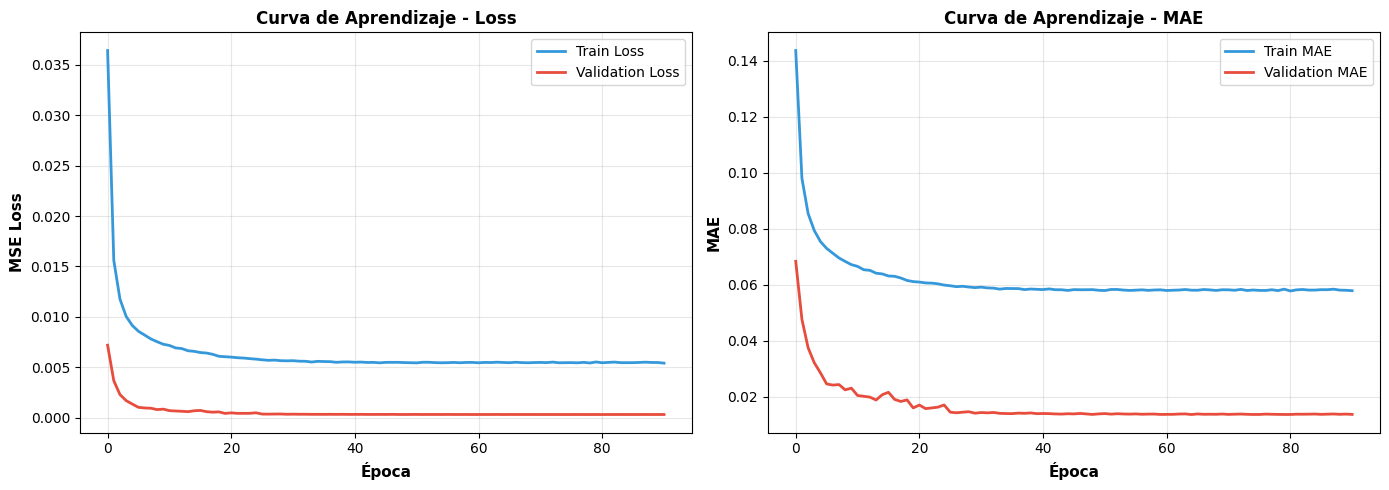

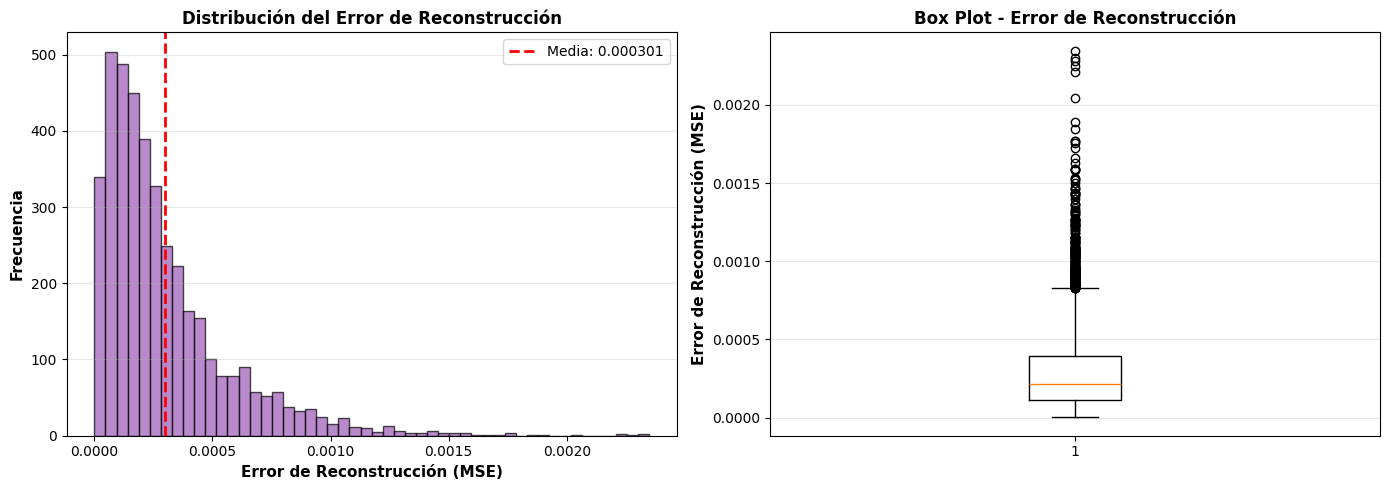

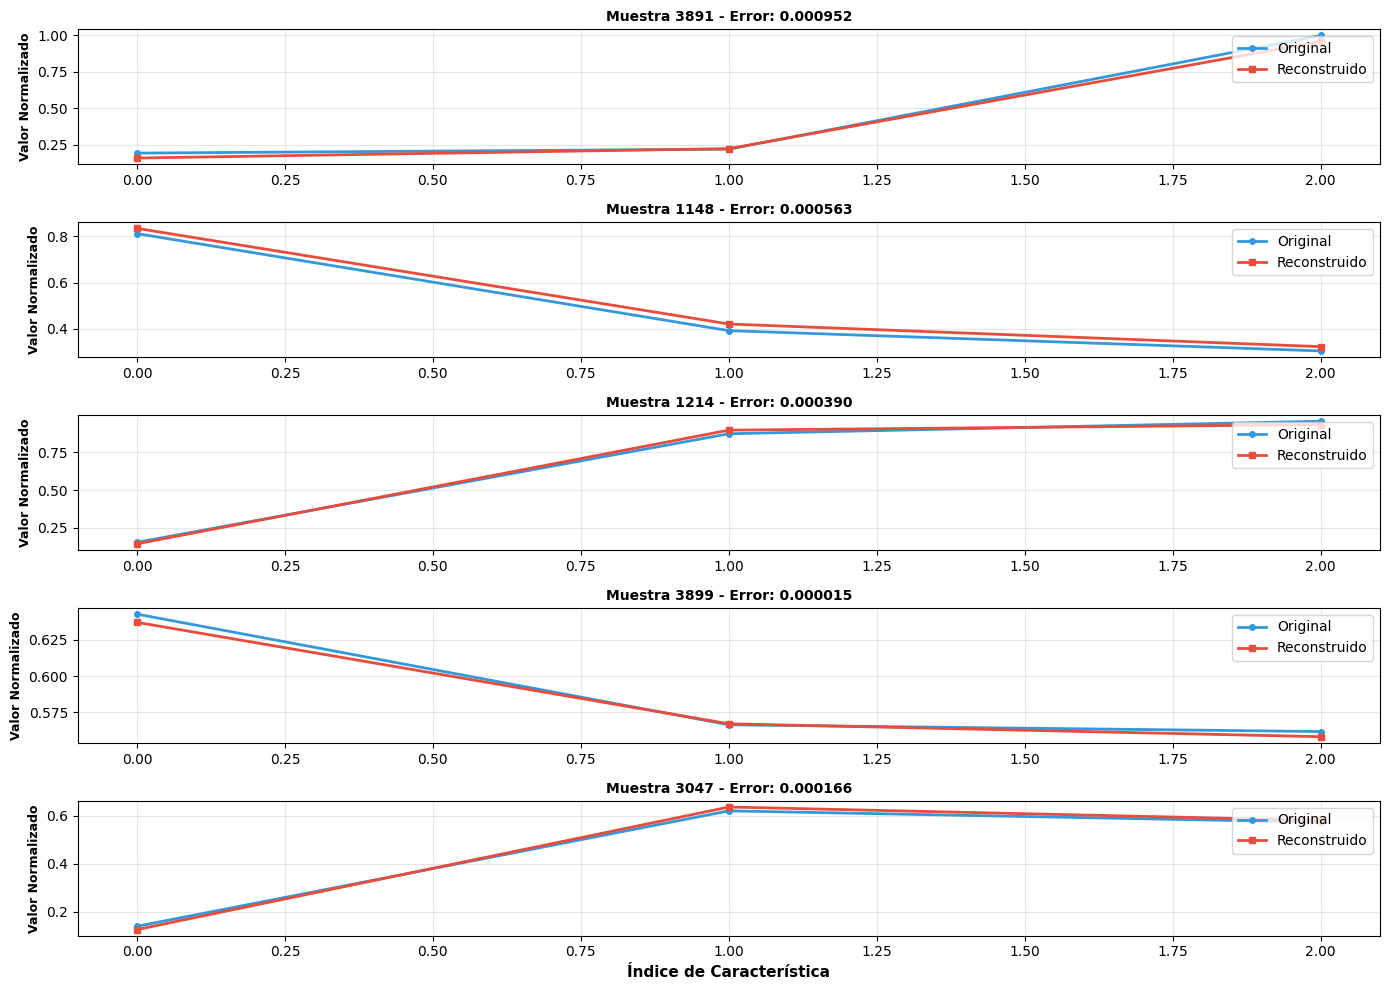

 Visualizando espacio latente...


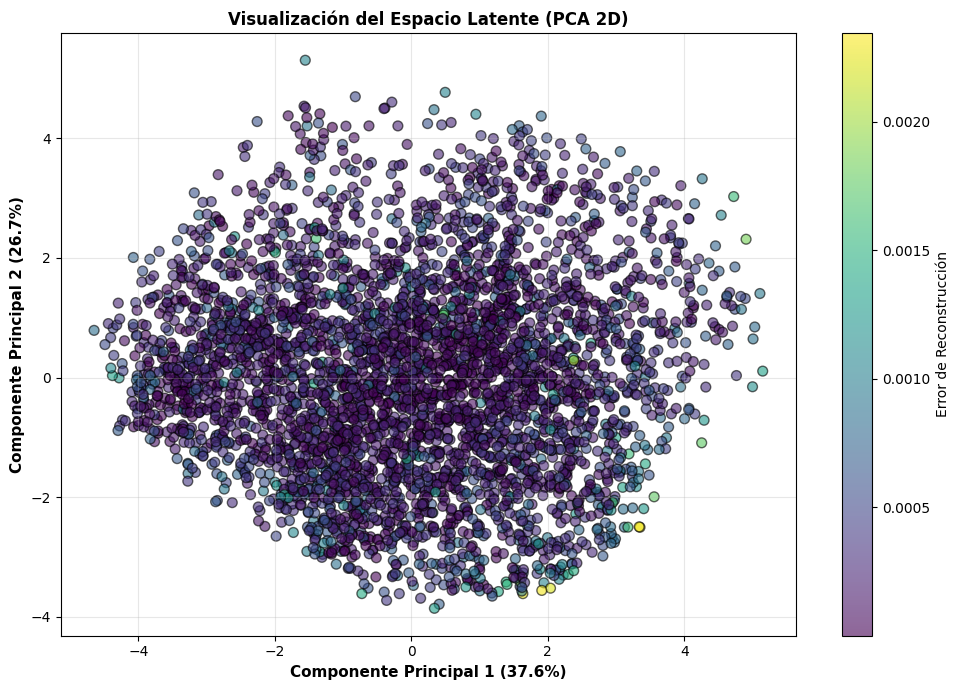

  Análisis de Anomalías:
  Umbral de detección: 0.000859
  Anomalías detectadas: 203 / 4056 (5.00%)
  Muestras normales: 3853
 Top 5 anomalías (mayor error de reconstrucción):
    1. Muestra 867: Error = 0.002347
    2. Muestra 2542: Error = 0.002300
    3. Muestra 1291: Error = 0.002281
    4. Muestra 1786: Error = 0.002248
    5. Muestra 1662: Error = 0.002210

RESUMEN FINAL - AUTOENCODER

IMPLEMENTACIÓN COMPLETADA
ESPECIFICACIONES DEL MODELO:
  Tipo: Autoencoder Profundo (Deep Autoencoder)
  Framework: TensorFlow/Keras
  Arquitectura: 3 → 32 → 16 → 8 → 16 → 32 → 3
  Factor de compresión: 0.38x
  Parámetros totales: 1,963

DATOS PROCESADOS:
  Total de muestras: 20276
  Características de entrada: 3
  Train: 16220 muestras (80%)
  Test: 4056 muestras (20%)
  Normalización: MinMaxScaler [0, 1]

ENTRENAMIENTO:
  Épocas ejecutadas: 91
  Batch size: 32
  Optimizer: Adam (lr=0.001)
  Loss function: MSE
  Callbacks: EarlyStopping, ReduceLROnPlateau

RESULTADOS:
  Train Loss (MSE): 0.000301


In [ ]:

# ==================== COMPILACIÓN ====================
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error para reconstrucción
    metrics=['mae']  # Mean Absolute Error como métrica adicional
)
# ==================== ENTRENAMIENTO ====================
# Callbacks para mejor entrenamiento
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Entrenar el autoencoder
history = autoencoder.fit(
    X_train_ae, X_train_ae,  # Input = Output (reconstrucción)
    epochs=100,
    batch_size=32,
    validation_data=(X_test_ae, X_test_ae),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ==================== EVALUACIÓN ====================
# Evaluar en conjunto de prueba
test_loss, test_mae = autoencoder.evaluate(X_test_ae, X_test_ae, verbose=0)
train_loss, train_mae = autoencoder.evaluate(X_train_ae, X_train_ae, verbose=0)

print(f"  MÉTRICAS DE RENDIMIENTO:")
print(f"  ENTRENAMIENTO:")
print(f"  MSE Loss: {train_loss:.6f}")
print(f"  MAE: {train_mae:.6f}")
print(f"  PRUEBA:")
print(f"  MSE Loss: {test_loss:.6f}")
print(f"  MAE: {test_mae:.6f}")
print(f"  GENERALIZACIÓN:")
# Usar la función abs nativa de Python (no la de PySpark)
diff_loss = float(train_loss) - float(test_loss)
if diff_loss < 0:
    diff_loss = -diff_loss
print(f"  Diferencia Loss: {diff_loss:.6f}")

# Generar predicciones (reconstrucciones)
X_test_reconstructed = autoencoder.predict(X_test_ae, verbose=0)

# Calcular error de reconstrucción por muestra
reconstruction_error = np.mean(np.square(X_test_ae - X_test_reconstructed), axis=1)

print(f"  ERROR DE RECONSTRUCCIÓN:")
print(f"  Media: {np.mean(reconstruction_error):.6f}")
print(f"  Desviación estándar: {np.std(reconstruction_error):.6f}")
print(f"  Min: {np.min(reconstruction_error):.6f}")
print(f"  Max: {np.max(reconstruction_error):.6f}")

# ==================== VISUALIZACIONES ====================
# 1. Historial de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', color='#3498db', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
axes[0].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
axes[0].set_title('Curva de Aprendizaje - Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', color='#3498db', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='#e74c3c', linewidth=2)
axes[1].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[1].set_title('Curva de Aprendizaje - MAE', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Distribución del error de reconstrucción
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(reconstruction_error, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(reconstruction_error), color='r', linestyle='--', linewidth=2,
                label=f'Media: {np.mean(reconstruction_error):.6f}')
axes[0].set_xlabel('Error de Reconstrucción (MSE)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0].set_title('Distribución del Error de Reconstrucción', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(reconstruction_error, vert=True)
axes[1].set_ylabel('Error de Reconstrucción (MSE)', fontsize=11, fontweight='bold')
axes[1].set_title('Box Plot - Error de Reconstrucción', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Comparación Original vs Reconstruido (primeras 5 muestras)
n_samples = 5
sample_indices = np.random.choice(len(X_test_ae), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 1, figsize=(14, 10))

for idx, sample_idx in enumerate(sample_indices):
    original = X_test_ae[sample_idx]
    reconstructed = X_test_reconstructed[sample_idx]

    x_pos = np.arange(len(original))
    axes[idx].plot(x_pos, original, 'o-', label='Original', color='#3498db', linewidth=2, markersize=4)
    axes[idx].plot(x_pos, reconstructed, 's-', label='Reconstruido', color='#e74c3c', linewidth=2, markersize=4)
    axes[idx].set_ylabel('Valor Normalizado', fontsize=9, fontweight='bold')
    axes[idx].set_title(f'Muestra {sample_idx + 1} - Error: {reconstruction_error[sample_idx]:.6f}',
                        fontsize=10, fontweight='bold')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(alpha=0.3)

axes[-1].set_xlabel('Índice de Característica', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Visualización del espacio latente (usando PCA para 2D)
print(" Visualizando espacio latente...")
latent_representations = encoder_model.predict(X_test_ae, verbose=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                     c=reconstruction_error,
                     cmap='viridis',
                     alpha=0.6,
                     s=50,
                     edgecolors='black')
plt.colorbar(scatter, label='Error de Reconstrucción')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
          fontsize=11, fontweight='bold')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
          fontsize=11, fontweight='bold')
plt.title('Visualización del Espacio Latente (PCA 2D)', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==================== DETECCIÓN DE ANOMALÍAS ====================
# Definir umbral de anomalía (mean + 2*std)
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
anomalies = reconstruction_error > threshold
n_anomalies = np.sum(anomalies)

print(f"  Análisis de Anomalías:")
print(f"  Umbral de detección: {threshold:.6f}")
print(f"  Anomalías detectadas: {n_anomalies} / {len(X_test_ae)} ({n_anomalies/len(X_test_ae)*100:.2f}%)")
print(f"  Muestras normales: {len(X_test_ae) - n_anomalies}")

if n_anomalies > 0:
    print(f" Top 5 anomalías (mayor error de reconstrucción):")
    top_anomaly_indices = np.argsort(reconstruction_error)[-5:][::-1]
    for i, idx in enumerate(top_anomaly_indices, 1):
        print(f"    {i}. Muestra {idx}: Error = {reconstruction_error[idx]:.6f}")

# ==================== RESUMEN FINAL ====================
print("\n" + "=" * 80)
print("RESUMEN FINAL - AUTOENCODER")
print("=" * 80)

RESUMEN_AUTOENCODER = f"""
IMPLEMENTACIÓN COMPLETADA
ESPECIFICACIONES DEL MODELO:
  Tipo: Autoencoder Profundo (Deep Autoencoder)
  Framework: TensorFlow/Keras
  Arquitectura: {input_dim} → {encoding_dim_layer1} → {encoding_dim_layer2} → {latent_dim} → {encoding_dim_layer2} → {encoding_dim_layer1} → {input_dim}
  Factor de compresión: {input_dim / latent_dim:.2f}x
  Parámetros totales: {autoencoder.count_params():,}

DATOS PROCESADOS:
  Total de muestras: {len(data_normalized)}
  Características de entrada: {input_dim}
  Train: {len(X_train_ae)} muestras (80%)
  Test: {len(X_test_ae)} muestras (20%)
  Normalización: MinMaxScaler [0, 1]

ENTRENAMIENTO:
  Épocas ejecutadas: {len(history.history['loss'])}
  Batch size: 32
  Optimizer: Adam (lr=0.001)
  Loss function: MSE
  Callbacks: EarlyStopping, ReduceLROnPlateau

RESULTADOS:
  Train Loss (MSE): {train_loss:.6f}
  Test Loss (MSE): {test_loss:.6f}
  Test MAE: {test_mae:.6f}
  Generalización: {'✓ Buena' if diff_loss < 0.01 else '⚠ Regular'}

DETECCIÓN DE ANOMALÍAS:
  Umbral: {threshold:.6f}
  Anomalías: {n_anomalies} ({n_anomalies/len(X_test_ae)*100:.2f}%)
  Muestras normales: {len(X_test_ae) - n_anomalies}

APLICACIONES:
  Reducción de dimensionalidad ({input_dim}D → {latent_dim}D)
  Detección de anomalías en producción agrícola
  Extracción de características latentes
  Compresión de datos para almacenamiento eficiente
  Preprocesamiento para otros modelos ML

════════════════════════════════════════════════════════════════
"""

print(RESUMEN_AUTOENCODER)


In [ ]:
import os

!pip install pyspark tensorflow scikit-learn matplotlib seaborn

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

os.environ["SPARKML_TEMP_DFS_PATH"] = "/Volumes/workspace/ml_eva2/eva2/sparkml_temp"

spark = SparkSession.builder.appName("AgriculturalYieldPrediction").getOrCreate()
spark.conf.set("spark.sql.shuffle.partitions", "200")

print("✓ Sesión Spark iniciada")
print(f"  Versión: {spark.version}")

archivo_csv = "/content/DATASET_DEFINITIVO.csv"

if not os.path.exists(archivo_csv):
    raise FileNotFoundError(f"El archivo CSV no se encontró en la ruta especificada: {archivo_csv}")

try:
    df_spark = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(archivo_csv)
    print(f"  Ruta: {archivo_csv}")
    print(f"  Carga exitosa")
except Exception as e:
    print(f"Error al cargar el archivo CSV: {e}")

✓ Sesión Spark iniciada
  Versión: 3.5.1
  Ruta: /content/DATASET_DEFINITIVO.csv
  Carga exitosa


In [ ]:
import os
import joblib

# Define paths for saving models and scalers
model_save_path = "./saved_models"
os.makedirs(model_save_path, exist_ok=True)

# 1. Save Spark MLlib best_model (RandomForestRegressor)
spark_rf_model_path = os.path.join(model_save_path, "spark_random_forest_model")
try:
    best_model.save(spark_rf_model_path)
    print(f"✓ Spark RandomForestRegressor model guardado en: {spark_rf_model_path}")
except Exception as e:
    print(f"Error al guardar Spark RandomForestRegressor model: {e}")

# 2. Save Keras autoencoder model
keras_autoencoder_model_path = os.path.join(model_save_path, "keras_autoencoder_model")
try:
    autoencoder.save(keras_autoencoder_model_path, save_format="tf")
    print(f"✓ Keras Autoencoder model guardado en: {keras_autoencoder_model_path}")
except Exception as e:
    print(f"Error al guardar Keras Autoencoder model: {e}")

# 3. Save Spark MLlib scaler_model (StandardScaler)
spark_scaler_model_path = os.path.join(model_save_path, "spark_standard_scaler")
try:
    scaler_model.save(spark_scaler_model_path)
    print(f"✓ Spark StandardScaler model guardado en: {spark_scaler_model_path}")
except Exception as e:
    print(f"Error al guardar Spark StandardScaler model: {e}")

# 4. Save scikit-learn scaler_ae (MinMaxScaler)
sklearn_scaler_path = os.path.join(model_save_path, "sklearn_min_max_scaler.joblib")
try:
    joblib.dump(scaler_ae, sklearn_scaler_path)
    print(f"✓ scikit-learn MinMaxScaler guardado en: {sklearn_scaler_path}")
except Exception as e:
    print(f"Error al guardar scikit-learn MinMaxScaler: {e}")


Error al guardar Spark RandomForestRegressor model: An error occurred while calling o14032.save.
: java.io.IOException: Path ./saved_models/spark_random_forest_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4

In [ ]:
import os
import joblib

# Define paths for saving models and scalers
model_save_path = "./saved_models"
os.makedirs(model_save_path, exist_ok=True)

# 1. Save Spark MLlib best_model (RandomForestRegressor)
spark_rf_model_path = os.path.join(model_save_path, "spark_random_forest_model")
try:
    best_model.save(spark_rf_model_path)
    print(f"✓ Spark RandomForestRegressor model guardado en: {spark_rf_model_path}")
except Exception as e:
    print(f"Error al guardar Spark RandomForestRegressor model: {e}")

# 2. Save Keras autoencoder model
keras_autoencoder_model_path = os.path.join(model_save_path, "keras_autoencoder_model.keras") # Changed to .keras extension
try:
    autoencoder.save(keras_autoencoder_model_path) # Removed save_format="tf"
    print(f"✓ Keras Autoencoder model guardado en: {keras_autoencoder_model_path}")
except Exception as e:
    print(f"Error al guardar Keras Autoencoder model: {e}")

# 3. Save Spark MLlib scaler_model (StandardScaler)
spark_scaler_model_path = os.path.join(model_save_path, "spark_standard_scaler")
try:
    scaler_model.save(spark_scaler_model_path)
    print(f"✓ Spark StandardScaler model guardado en: {spark_scaler_model_path}")
except Exception as e:
    print(f"Error al guardar Spark StandardScaler model: {e}")

# 4. Save scikit-learn scaler_ae (MinMaxScaler)
sklearn_scaler_path = os.path.join(model_save_path, "sklearn_min_max_scaler.joblib")
try:
    joblib.dump(scaler_ae, sklearn_scaler_path)
    print(f"✓ scikit-learn MinMaxScaler guardado en: {sklearn_scaler_path}")
except Exception as e:
    print(f"Error al guardar scikit-learn MinMaxScaler: {e}")

Error al guardar Spark RandomForestRegressor model: An error occurred while calling o14114.save.
: java.io.IOException: Path ./saved_models/spark_random_forest_model already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4

In [ ]:
import os
import joblib

# Define paths for saving models and scalers
model_save_path = "./saved_models"
os.makedirs(model_save_path, exist_ok=True)

# 1. Save Spark MLlib best_model (RandomForestRegressor)
spark_rf_model_path = os.path.join(model_save_path, "spark_random_forest_model")
try:
    best_model.write().overwrite().save(spark_rf_model_path)
    print(f"✓ Spark RandomForestRegressor model guardado en: {spark_rf_model_path}")
except Exception as e:
    print(f"Error al guardar Spark RandomForestRegressor model: {e}")

# 2. Save Keras autoencoder model
keras_autoencoder_model_path = os.path.join(model_save_path, "keras_autoencoder_model.keras") # Changed to .keras extension
try:
    autoencoder.save(keras_autoencoder_model_path) # Removed save_format="tf"
    print(f"✓ Keras Autoencoder model guardado en: {keras_autoencoder_model_path}")
except Exception as e:
    print(f"Error al guardar Keras Autoencoder model: {e}")

# 3. Save Spark MLlib scaler_model (StandardScaler)
spark_scaler_model_path = os.path.join(model_save_path, "spark_standard_scaler")
try:
    scaler_model.write().overwrite().save(spark_scaler_model_path)
    print(f"✓ Spark StandardScaler model guardado en: {spark_scaler_model_path}")
except Exception as e:
    print(f"Error al guardar Spark StandardScaler model: {e}")

# 4. Save scikit-learn scaler_ae (MinMaxScaler)
sklearn_scaler_path = os.path.join(model_save_path, "sklearn_min_max_scaler.joblib")
try:
    joblib.dump(scaler_ae, sklearn_scaler_path)
    print(f"✓ scikit-learn MinMaxScaler guardado en: {sklearn_scaler_path}")
except Exception as e:
    print(f"Error al guardar scikit-learn MinMaxScaler: {e}")

✓ Spark RandomForestRegressor model guardado en: ./saved_models/spark_random_forest_model
✓ Keras Autoencoder model guardado en: ./saved_models/keras_autoencoder_model.keras
✓ Spark StandardScaler model guardado en: ./saved_models/spark_standard_scaler
✓ scikit-learn MinMaxScaler guardado en: ./saved_models/sklearn_min_max_scaler.joblib



AUMENTO DE DATOS - CAPA FEATURE ENGINEERING
 Aplicando aumento de datos (Factor: 3x)...
  Aumento de datos completado
  Dataset original: 20276 registros
  Dataset aumentado: 60828 registros
  Factor de crecimiento: 3.0x

 Estadísticas de Producción (Aumentado):
+-------+----------------------+
|summary|Yield_tons_per_hectare|
+-------+----------------------+
|  count|                 60828|
|   mean|     4.643100187157364|
| stddev|    1.7073475350173326|
|    min|   -0.4692287826459278|
|    max|     9.727003962492544|
+-------+----------------------+



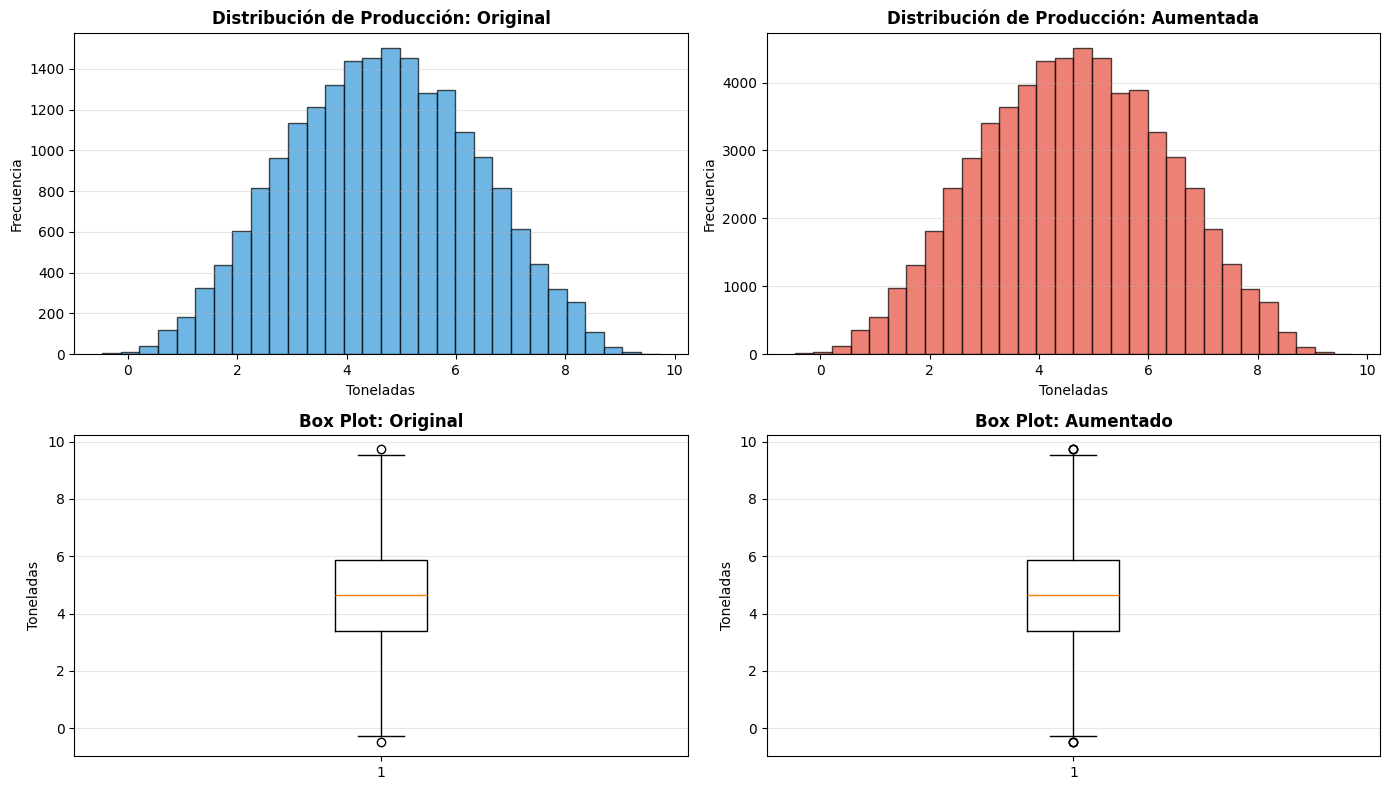

✓ Visualización de aumento completada


In [ ]:
from pyspark.ml.linalg import Vectors
print("\n" + "=" * 80)
print("AUMENTO DE DATOS - CAPA FEATURE ENGINEERING")
print("=" * 80)

def augment_data_spark(df, multiplicador=3, noise_level=0.1, seed=42):
    np.random.seed(seed)
    dfs = [df]
    for i in range(multiplicador - 1):
        # COMENTARIO: Convertir un Spark DataFrame a Pandas DataFrame (.toPandas())
        # esta operación fuerza a Spark a recolectar todos los datos del clúster y cargarlos
        # en la memoria del driver. Para grandes datasets, esto puede causar OutOfMemoryError.
        df_pandas = df.toPandas()
        features_augmented = []
        for _, row in df_pandas.iterrows():
            feature_vec = row['features_scaled'].toArray()
            noise = np.random.normal(0, noise_level, len(feature_vec))
            feature_noisy = feature_vec + noise
            scale_factor = np.random.uniform(0.85, 1.15, len(feature_vec))
            feature_scaled = feature_noisy * scale_factor
            features_augmented.append(feature_scaled)
        df_pandas['features_scaled'] = [Vectors.dense(f) for f in features_augmented]
        schema = df.schema
        df_augmented_spark = spark.createDataFrame(df_pandas, schema=schema)
        dfs.append(df_augmented_spark)
    result = dfs[0]
    for df_add in dfs[1:]:
        result = result.union(df_add)
    return result

multiplicador = 3
print(f" Aplicando aumento de datos (Factor: {multiplicador}x)...")

df_augmented = augment_data_spark(df_processed, multiplicador=multiplicador)

row_count_augmented = df_augmented.count()

print(f"  Aumento de datos completado")
print(f"  Dataset original: {df_processed.count()} registros")
print(f"  Dataset aumentado: {row_count_augmented} registros")
print(f"  Factor de crecimiento: {row_count_augmented / df_processed.count():.1f}x")

print(f"\n Estadísticas de Producción (Aumentado):")
df_augmented.select(COLUMNA_TARGET).describe().show()

df_augmented_viz = df_augmented.select(COLUMNA_TARGET).toPandas()
df_processed_viz = df_processed.select(COLUMNA_TARGET).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes[0, 0].hist(df_processed_viz[COLUMNA_TARGET], bins=30, alpha=0.7, color='#3498db', edgecolor='black')
axes[0, 0].set_title('Distribución de Producción: Original', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Toneladas')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 1].hist(df_augmented_viz[COLUMNA_TARGET], bins=30, alpha=0.7, color='#e74c3c', edgecolor='black')
axes[0, 1].set_title('Distribución de Producción: Aumentada', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Toneladas')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[1, 0].boxplot(df_processed_viz[COLUMNA_TARGET], vert=True)
axes[1, 0].set_title('Box Plot: Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Toneladas')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 1].boxplot(df_augmented_viz[COLUMNA_TARGET], vert=True)
axes[1, 1].set_title('Box Plot: Aumentado', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Toneladas')
axes[1, 1].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
print("✓ Visualización de aumento completada")

In [ ]:
print("=" * 80)
print("PASO 1: CARGA DEL CONJUNTO DE DATOS PARA AUTOENCODER")
print("=" * 80)

# Importar librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df_autoencoder = df_clean.select(feature_cols).toPandas()

print(f"  {len(df_autoencoder)}")
print(f"  {len(df_autoencoder.columns)}")
print(df_autoencoder.head())

# Normalización de datos con MinMaxScaler (0-1)
scaler_ae = MinMaxScaler()
data_normalized = scaler_ae.fit_transform(df_autoencoder)

print(f"  [{df_autoencoder.min().min():.2f}, {df_autoencoder.max().max():.2f}]")
print(f"  [{data_normalized.min():.2f}, {data_normalized.max():.2f}]")

# División en conjuntos de entrenamiento y prueba
X_train_ae, X_test_ae = train_test_split(data_normalized, test_size=0.2, random_state=42)

print(f"  Train: {X_train_ae.shape[0]} muestras")
print(f"  Test: {X_test_ae.shape[0]} muestras")

PASO 1: CARGA DEL CONJUNTO DE DATOS PARA AUTOENCODER
  20276
  3
   Rainfall_mm  Temperature_Celsius  Days_to_Harvest
0   147.998025            29.794042              106
1   730.379174            31.620687              110
2   357.902357            31.593431               90
3   181.587861            26.752729              127
4   395.048968            17.646199              140
  [15.00, 999.95]
  [0.00, 1.00]
  Train: 16220 muestras
  Test: 4056 muestras


In [ ]:
print("=" * 80)
print("PASO 1: CARGA DEL CONJUNTO DE DATOS PARA AUTOENCODER")
print("=" * 80)

# Importar librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Establecer seed para reproducibilidad de TensorFlow/Keras
tf.random.set_seed(42)

df_autoencoder = df_clean.select(feature_cols).toPandas()

print(f"  {len(df_autoencoder)}")
print(f"  {len(df_autoencoder.columns)}")
print(df_autoencoder.head())

# Normalización de datos con MinMaxScaler (0-1)
scaler_ae = MinMaxScaler()
data_normalized = scaler_ae.fit_transform(df_autoencoder)

print(f"  [{df_autoencoder.min().min():.2f}, {df_autoencoder.max().max():.2f}]")
print(f"  [{data_normalized.min():.2f}, {data_normalized.max():.2f}]")

# División en conjuntos de entrenamiento y prueba
X_train_ae, X_test_ae = train_test_split(data_normalized, test_size=0.2, random_state=42)

print(f"  Train: {X_train_ae.shape[0]} muestras")
print(f"  Test: {X_test_ae.shape[0]} muestras")

PASO 1: CARGA DEL CONJUNTO DE DATOS PARA AUTOENCODER
  20276
  3
   Rainfall_mm  Temperature_Celsius  Days_to_Harvest
0   147.998025            29.794042              106
1   730.379174            31.620687              110
2   357.902357            31.593431               90
3   181.587861            26.752729              127
4   395.048968            17.646199              140
  [15.00, 999.95]
  [0.00, 1.00]
  Train: 16220 muestras
  Test: 4056 muestras


Epoch 1/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 0.0056 - mae: 0.0590 - val_loss: 5.7803e-04 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 2/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056 - mae: 0.0589 - val_loss: 5.4091e-04 - val_mae: 0.0184 - learning_rate: 0.0010
Epoch 3/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0055 - mae: 0.0584 - val_loss: 5.3697e-04 - val_mae: 0.0183 - learning_rate: 0.0010
Epoch 4/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0053 - mae: 0.0575 - val_loss: 4.4752e-04 - val_mae: 0.0170 - learning_rate: 0.0010
Epoch 5/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0054 - mae: 0.0578 - val_loss: 5.0079e-04 - val_mae: 0.0178 - learning_rate: 0.0010
Epoch 6/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0053 - mae: 0.0571 - val_loss: 4.9247e-04 - val_mae: 0.0172 - learning_rate: 0.0010
Epoch 7/100
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0053 - mae: 0.0574 - val_loss: 4.0463e-04 - val_mae: 

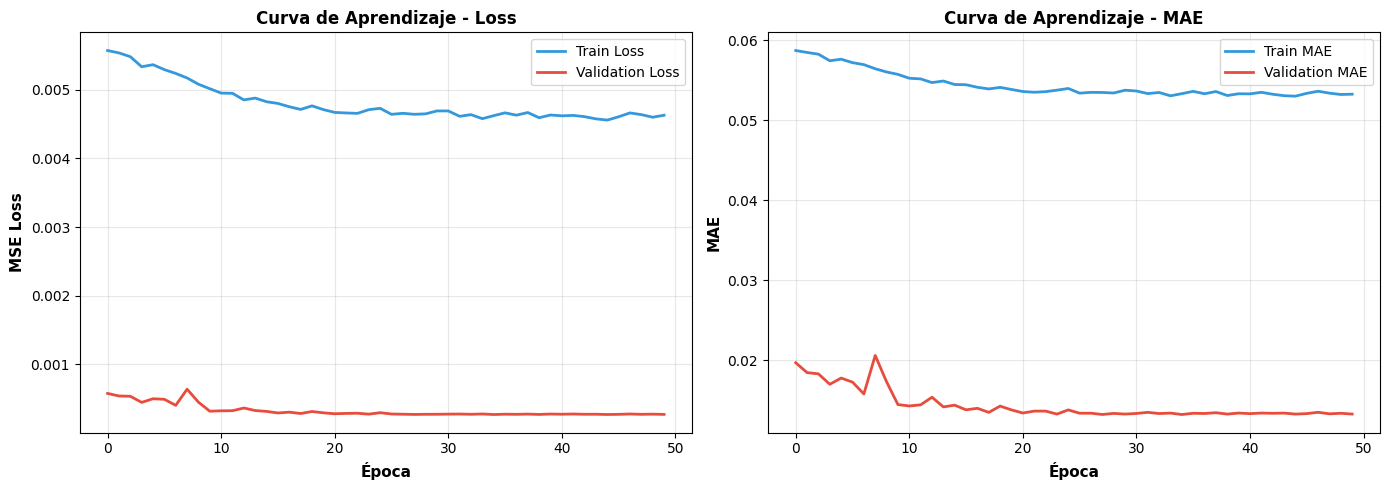

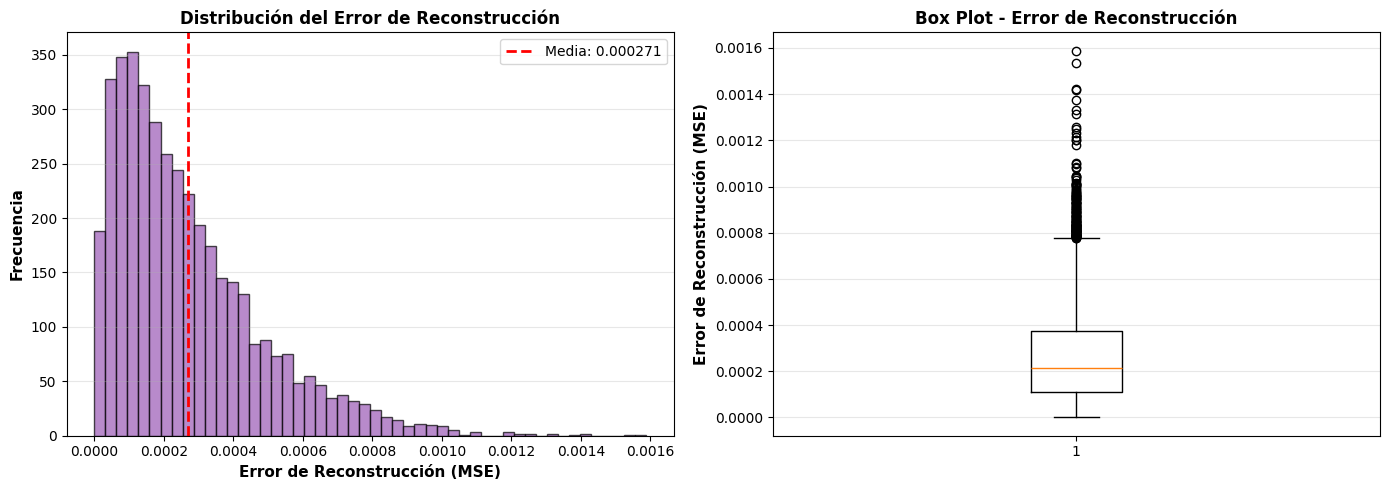

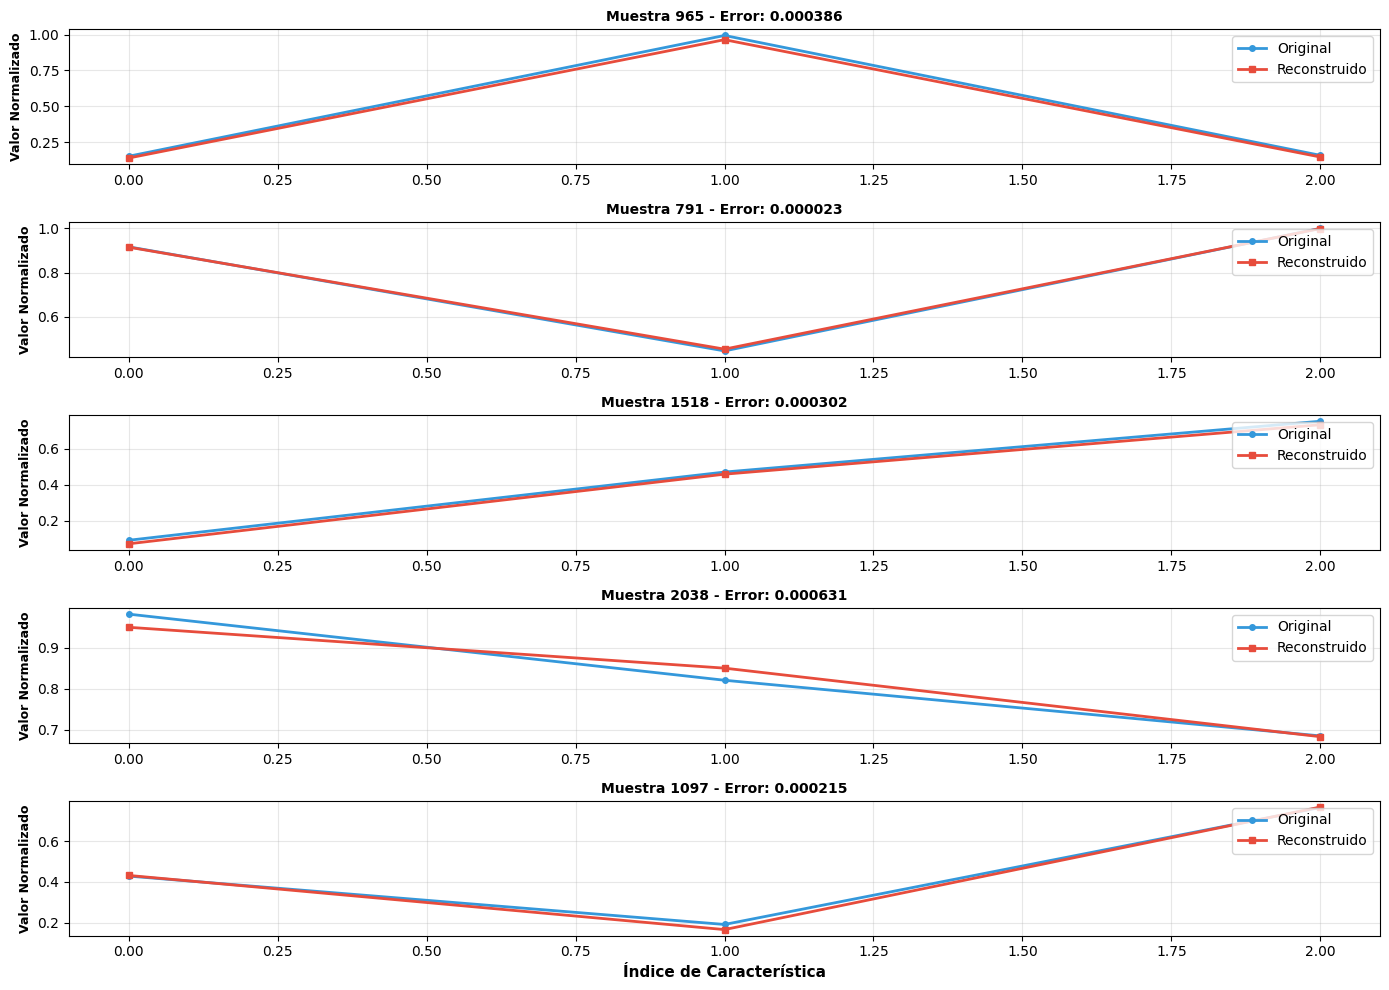

 Visualizando espacio latente...


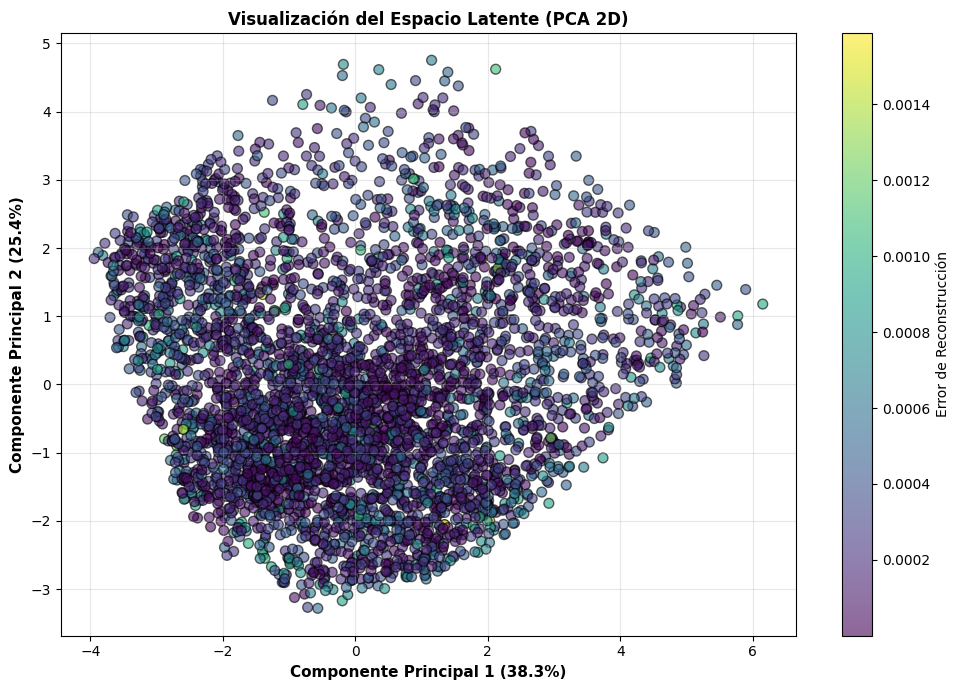

  Análisis de Anomalías:
  Umbral de detección: 0.000701
  Anomalías detectadas: 210 / 4056 (5.18%)
  Muestras normales: 3846
 Top 5 anomalías (mayor error de reconstrucción):
    1. Muestra 867: Error = 0.001588
    2. Muestra 1291: Error = 0.001534
    3. Muestra 1004: Error = 0.001424
    4. Muestra 3699: Error = 0.001419
    5. Muestra 743: Error = 0.001373

RESUMEN FINAL - AUTOENCODER

IMPLEMENTACIÓN COMPLETADA
ESPECIFICACIONES DEL MODELO:
  Tipo: Autoencoder Profundo (Deep Autoencoder)
  Framework: TensorFlow/Keras
  Arquitectura: 3 → 32 → 16 → 8 → 16 → 32 → 3
  Factor de compresión: 0.38x
  Parámetros totales: 1,963

DATOS PROCESADOS:
  Total de muestras: 20276
  Características de entrada: 3
  Train: 16220 muestras (80%)
  Test: 4056 muestras (20%)
  Normalización: MinMaxScaler [0, 1]

ENTRENAMIENTO:
  Épocas ejecutadas: 50
  Batch size: 32
  Optimizer: Adam (lr=0.001)
  Loss function: MSE
  Callbacks: EarlyStopping, ReduceLROnPlateau

RESULTADOS:
  Train Loss (MSE): 0.000270
 

In [ ]:
# ==================== COMPILACIÓN ====================
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # "Mean Squared Error" para reconstrucción
    metrics=['mae']  # "Mean Absolute Error" como métrica adicional
)
# ==================== ENTRENAMIENTO ====================
# Callbacks para mejor entrenamiento
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Entrenar el autoencoder
history = autoencoder.fit(
    X_train_ae, X_train_ae,  # Input = Output (reconstrucción)
    epochs=100,
    batch_size=32,
    validation_data=(X_test_ae, X_test_ae),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ==================== EVALUACIÓN ====================
# Evaluar en conjunto de prueba
test_loss, test_mae = autoencoder.evaluate(X_test_ae, X_test_ae, verbose=0)
train_loss, train_mae = autoencoder.evaluate(X_train_ae, X_train_ae, verbose=0)

print(f"  MÉTRICAS DE RENDIMIENTO:")
print(f"  ENTRENAMIENTO:")
print(f"  MSE Loss: {train_loss:.6f}")
print(f"  MAE: {train_mae:.6f}")
print(f"  PRUEBA:")
print(f"  MSE Loss: {test_loss:.6f}")
print(f"  MAE: {test_mae:.6f}")
print(f"  GENERALIZACIÓN:")
# Usar la función abs nativa de Python (no la de PySpark)
diff_loss = float(train_loss) - float(test_loss)
if diff_loss < 0:
    diff_loss = -diff_loss
print(f"  Diferencia Loss: {diff_loss:.6f}")

# Generar predicciones (reconstrucciones)
X_test_reconstructed = autoencoder.predict(X_test_ae, verbose=0)

# Calcular error de reconstrucción por muestra
reconstruction_error = np.mean(np.square(X_test_ae - X_test_reconstructed), axis=1)

print(f"  ERROR DE RECONSTRUCCIÓN:")
print(f"  Media: {np.mean(reconstruction_error):.6f}")
print(f"  Desviación estándar: {np.std(reconstruction_error):.6f}")
print(f"  Min: {np.min(reconstruction_error):.6f}")
print(f"  Max: {np.max(reconstruction_error):.6f}")

# ==================== VISUALIZACIONES ====================
# 1. Historial de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', color='#3498db', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='#e74c3c', linewidth=2)
axes[0].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[0].set_ylabel('MSE Loss', fontsize=11, fontweight='bold')
axes[0].set_title('Curva de Aprendizaje - Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', color='#3498db', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='#e74c3c', linewidth=2)
axes[1].set_xlabel('Época', fontsize=11, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[1].set_title('Curva de Aprendizaje - MAE', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Distribución del error de reconstrucción
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(reconstruction_error, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(reconstruction_error), color='r', linestyle='--', linewidth=2,
                label=f'Media: {np.mean(reconstruction_error):.6f}')
axes[0].set_xlabel('Error de Reconstrucción (MSE)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
axes[0].set_title('Distribución del Error de Reconstrucción', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(reconstruction_error, vert=True)
axes[1].set_ylabel('Error de Reconstrucción (MSE)', fontsize=11, fontweight='bold')
axes[1].set_title('Box Plot - Error de Reconstrucción', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Comparación Original vs Reconstruido (primeras 5 muestras)
n_samples = 5
np.random.seed(42) # Ensure reproducibility for sample selection
sample_indices = np.random.choice(len(X_test_ae), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 1, figsize=(14, 10))

for idx, sample_idx in enumerate(sample_indices):
    original = X_test_ae[sample_idx]
    reconstructed = X_test_reconstructed[sample_idx]

    x_pos = np.arange(len(original))
    axes[idx].plot(x_pos, original, 'o-', label='Original', color='#3498db', linewidth=2, markersize=4)
    axes[idx].plot(x_pos, reconstructed, 's-', label='Reconstruido', color='#e74c3c', linewidth=2, markersize=4)
    axes[idx].set_ylabel('Valor Normalizado', fontsize=9, fontweight='bold')
    axes[idx].set_title(f'Muestra {sample_idx + 1} - Error: {reconstruction_error[sample_idx]:.6f}',
                        fontsize=10, fontweight='bold')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(alpha=0.3)

axes[-1].set_xlabel('Índice de Característica', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Visualización del espacio latente (usando PCA para 2D)
print(" Visualizando espacio latente...")
latent_representations = encoder_model.predict(X_test_ae, verbose=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                     c=reconstruction_error,
                     cmap='viridis',
                     alpha=0.6,
                     s=50,
                     edgecolors='black')
plt.colorbar(scatter, label='Error de Reconstrucción')
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
          fontsize=11, fontweight='bold')
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
          fontsize=11, fontweight='bold')
plt.title('Visualización del Espacio Latente (PCA 2D)', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==================== DETECCIÓN DE ANOMALÍAS ====================
# Definir umbral de anomalía (mean + 2*std)
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
anomalies = reconstruction_error > threshold
n_anomalies = np.sum(anomalies)

print(f"  Análisis de Anomalías:")
print(f"  Umbral de detección: {threshold:.6f}")
print(f"  Anomalías detectadas: {n_anomalies} / {len(X_test_ae)} ({n_anomalies/len(X_test_ae)*100:.2f}%)")
print(f"  Muestras normales: {len(X_test_ae) - n_anomalies}")

if n_anomalies > 0:
    print(f" Top 5 anomalías (mayor error de reconstrucción):")
    top_anomaly_indices = np.argsort(reconstruction_error)[-5:][::-1]
    for i, idx in enumerate(top_anomaly_indices, 1):
        print(f"    {i}. Muestra {idx}: Error = {reconstruction_error[idx]:.6f}")

# ==================== RESUMEN FINAL ====================
print("\n" + "=" * 80)
print("RESUMEN FINAL - AUTOENCODER")
print("=" * 80)

RESUMEN_AUTOENCODER = f"""
IMPLEMENTACIÓN COMPLETADA
ESPECIFICACIONES DEL MODELO:
  Tipo: Autoencoder Profundo (Deep Autoencoder)
  Framework: TensorFlow/Keras
  Arquitectura: {input_dim} \u2192 {encoding_dim_layer1} \u2192 {encoding_dim_layer2} \u2192 {latent_dim} \u2192 {encoding_dim_layer2} \u2192 {encoding_dim_layer1} \u2192 {input_dim}
  Factor de compresión: {input_dim / latent_dim:.2f}x
  Parámetros totales: {autoencoder.count_params():,}

DATOS PROCESADOS:
  Total de muestras: {len(data_normalized)}
  Características de entrada: {input_dim}
  Train: {len(X_train_ae)} muestras (80%)
  Test: {len(X_test_ae)} muestras (20%)
  Normalización: MinMaxScaler [0, 1]

ENTRENAMIENTO:
  \u00c9pocas ejecutadas: {len(history.history['loss'])}
  Batch size: 32
  Optimizer: Adam (lr=0.001)
  Loss function: MSE
  Callbacks: EarlyStopping, ReduceLROnPlateau

RESULTADOS:
  Train Loss (MSE): {train_loss:.6f}
  Test Loss (MSE): {test_loss:.6f}
  Test MAE: {test_mae:.6f}
  Generalización: {'\u2713 Buena' if diff_loss < 0.01 else '\u26a0 Regular'}

DETECCI\u00d3N DE ANOMAL\u00cdAS:
  Umbral: {threshold:.6f}
  Anomalías: {n_anomalies} ({n_anomalies/len(X_test_ae)*100:.2f}%)
  Muestras normales: {len(X_test_ae) - n_anomalies}

APLICACIONES:
  Reducción de dimensionalidad ({input_dim}D \u2192 {latent_dim}D)
  Detección de anomalías en producción agrícola
  Extracción de características latentes
  Compresión de datos para almacenamiento eficiente
  Preprocesamiento para otros modelos ML

\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\u2550\n"""

print(RESUMEN_AUTOENCODER)
